In [8]:
import glob
from functools import reduce
import cartopy.crs as ccrs
import cartopy.feature as cf
import cftime as cf
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import regionmask
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from IPython.display import Markdown
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Prepare for units transformation from mm/year to m3/year
mm_to_m = 10**(-3)
mm_per_s_to_mm_per_day = 86400.0

lnd_area_ctsm_f09_g17 =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2
mask_lnd_ctsm_f09_g17 = xr.open_dataset('/glade/u/home/staranu/useful_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
ctsm_f09_g17_mm_per_year_to_km3_per_year_transform = mm_per_s_to_mm_per_day*mm_to_m*lnd_area_ctsm_f09_g17/(10**9)

lon_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LONGXY'].values[0]
lat_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LATIXY'].values[:,0]

In [10]:
# Read the output data for the simulation with sector water usage on
path_simulation_data_with_sector_water_abstractions = "/glade/work/staranu/paper1_data_simulations/paper1_sectorwater_run.clm2.h1.1971-2010.nc"
output_data_sectorwater_simulation = xr.open_dataset(path_simulation_data_with_sector_water_abstractions, decode_times=False)

In [11]:
sectoral_fluxes_expected = ["DOM_EXPECTED_WITHD", "LIV_EXPECTED_WITHD", "ELEC_EXPECTED_WITHD", "MFC_EXPECTED_WITHD", "MIN_EXPECTED_WITHD", "QIRRIG_DEMAND", "DOM_EXPECTED_CONS",  "LIV_EXPECTED_CONS",  "ELEC_EXPECTED_CONS",  "MFC_EXPECTED_CONS",  "MIN_EXPECTED_CONS"]
sectoral_fluxes_actual   = ["DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD", "QIRRIG_FROM_SURFACE", "DOM_ACTUAL_CONS",  "LIV_ACTUAL_CONS",  "ELEC_ACTUAL_CONS",  "MFC_ACTUAL_CONS",  "MIN_ACTUAL_CONS"]

expected_volumetric_data = np.zeros((11, 30, 55296)) # in km3/day
actual_volumetric_data   = np.zeros((11, 30, 55296)) # in km3/day

In [12]:
for flux in range(0, 10):
    for day in range(0+30*365, 30+365*30):
        expected_volumetric_data[flux, day-30*365, :] = (output_data_sectorwater_simulation[sectoral_fluxes_expected[flux]])[day, :].values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
        actual_volumetric_data[flux, day-30*365, :]   = (output_data_sectorwater_simulation[sectoral_fluxes_actual[flux]])[day, :].values.flatten()*ctsm_f09_g17_mm_per_year_to_km3_per_year_transform
    print("Completed computation for " + str(sectoral_fluxes_expected[flux]) + " and " + str(sectoral_fluxes_actual[flux]))
        

Completed computation for DOM_EXPECTED_WITHD and DOM_ACTUAL_WITHD
Completed computation for LIV_EXPECTED_WITHD and LIV_ACTUAL_WITHD
Completed computation for ELEC_EXPECTED_WITHD and ELEC_ACTUAL_WITHD
Completed computation for MFC_EXPECTED_WITHD and MFC_ACTUAL_WITHD
Completed computation for MIN_EXPECTED_WITHD and MIN_ACTUAL_WITHD
Completed computation for QIRRIG_DEMAND and QIRRIG_FROM_SURFACE
Completed computation for DOM_EXPECTED_CONS and DOM_ACTUAL_CONS
Completed computation for LIV_EXPECTED_CONS and LIV_ACTUAL_CONS
Completed computation for ELEC_EXPECTED_CONS and ELEC_ACTUAL_CONS
Completed computation for MFC_EXPECTED_CONS and MFC_ACTUAL_CONS


In [13]:
# Filters for domestic part
filter_dom_and_liv = np.logical_and((np.isnan(actual_volumetric_data[0,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[1,:,:].ravel()) == False))

filter_dom_and_elec = np.logical_and((np.isnan(actual_volumetric_data[0,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[2,:,:].ravel()) == False))

filter_dom_and_mfc = np.logical_and((np.isnan(actual_volumetric_data[0,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[3,:,:].ravel()) == False))

filter_dom_and_min = np.logical_and((np.isnan(actual_volumetric_data[0,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[4,:,:].ravel()) == False))

filter_dom_and_irrig = np.logical_and((np.isnan(actual_volumetric_data[0,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[5,:,:].ravel()) == False))

# Filters for livestock part
filter_liv_and_elec = np.logical_and((np.isnan(actual_volumetric_data[1,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[2,:,:].ravel()) == False))

filter_liv_and_mfc = np.logical_and((np.isnan(actual_volumetric_data[1,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[3,:,:].ravel()) == False))

filter_liv_and_min = np.logical_and((np.isnan(actual_volumetric_data[1,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[4,:,:].ravel()) == False))

filter_liv_and_irrig = np.logical_and((np.isnan(actual_volumetric_data[1,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[5,:,:].ravel()) == False))


# Filters for thermoelectric part
filter_elec_and_mfc = np.logical_and((np.isnan(actual_volumetric_data[2,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[3,:,:].ravel()) == False))

filter_elec_and_min = np.logical_and((np.isnan(actual_volumetric_data[2,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[4,:,:].ravel()) == False))

filter_elec_and_irrig = np.logical_and((np.isnan(actual_volumetric_data[2,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[5,:,:].ravel()) == False))


# Filters for manufacturing part
filter_mfc_and_min = np.logical_and((np.isnan(actual_volumetric_data[3,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[4,:,:].ravel()) == False))

filter_mfc_and_irrig = np.logical_and((np.isnan(actual_volumetric_data[3,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[5,:,:].ravel()) == False))

# Filters for mining part
filter_min_and_irrig = np.logical_and((np.isnan(actual_volumetric_data[4,:,:].ravel()) == False), (np.isnan(actual_volumetric_data[5,:,:].ravel()) == False))



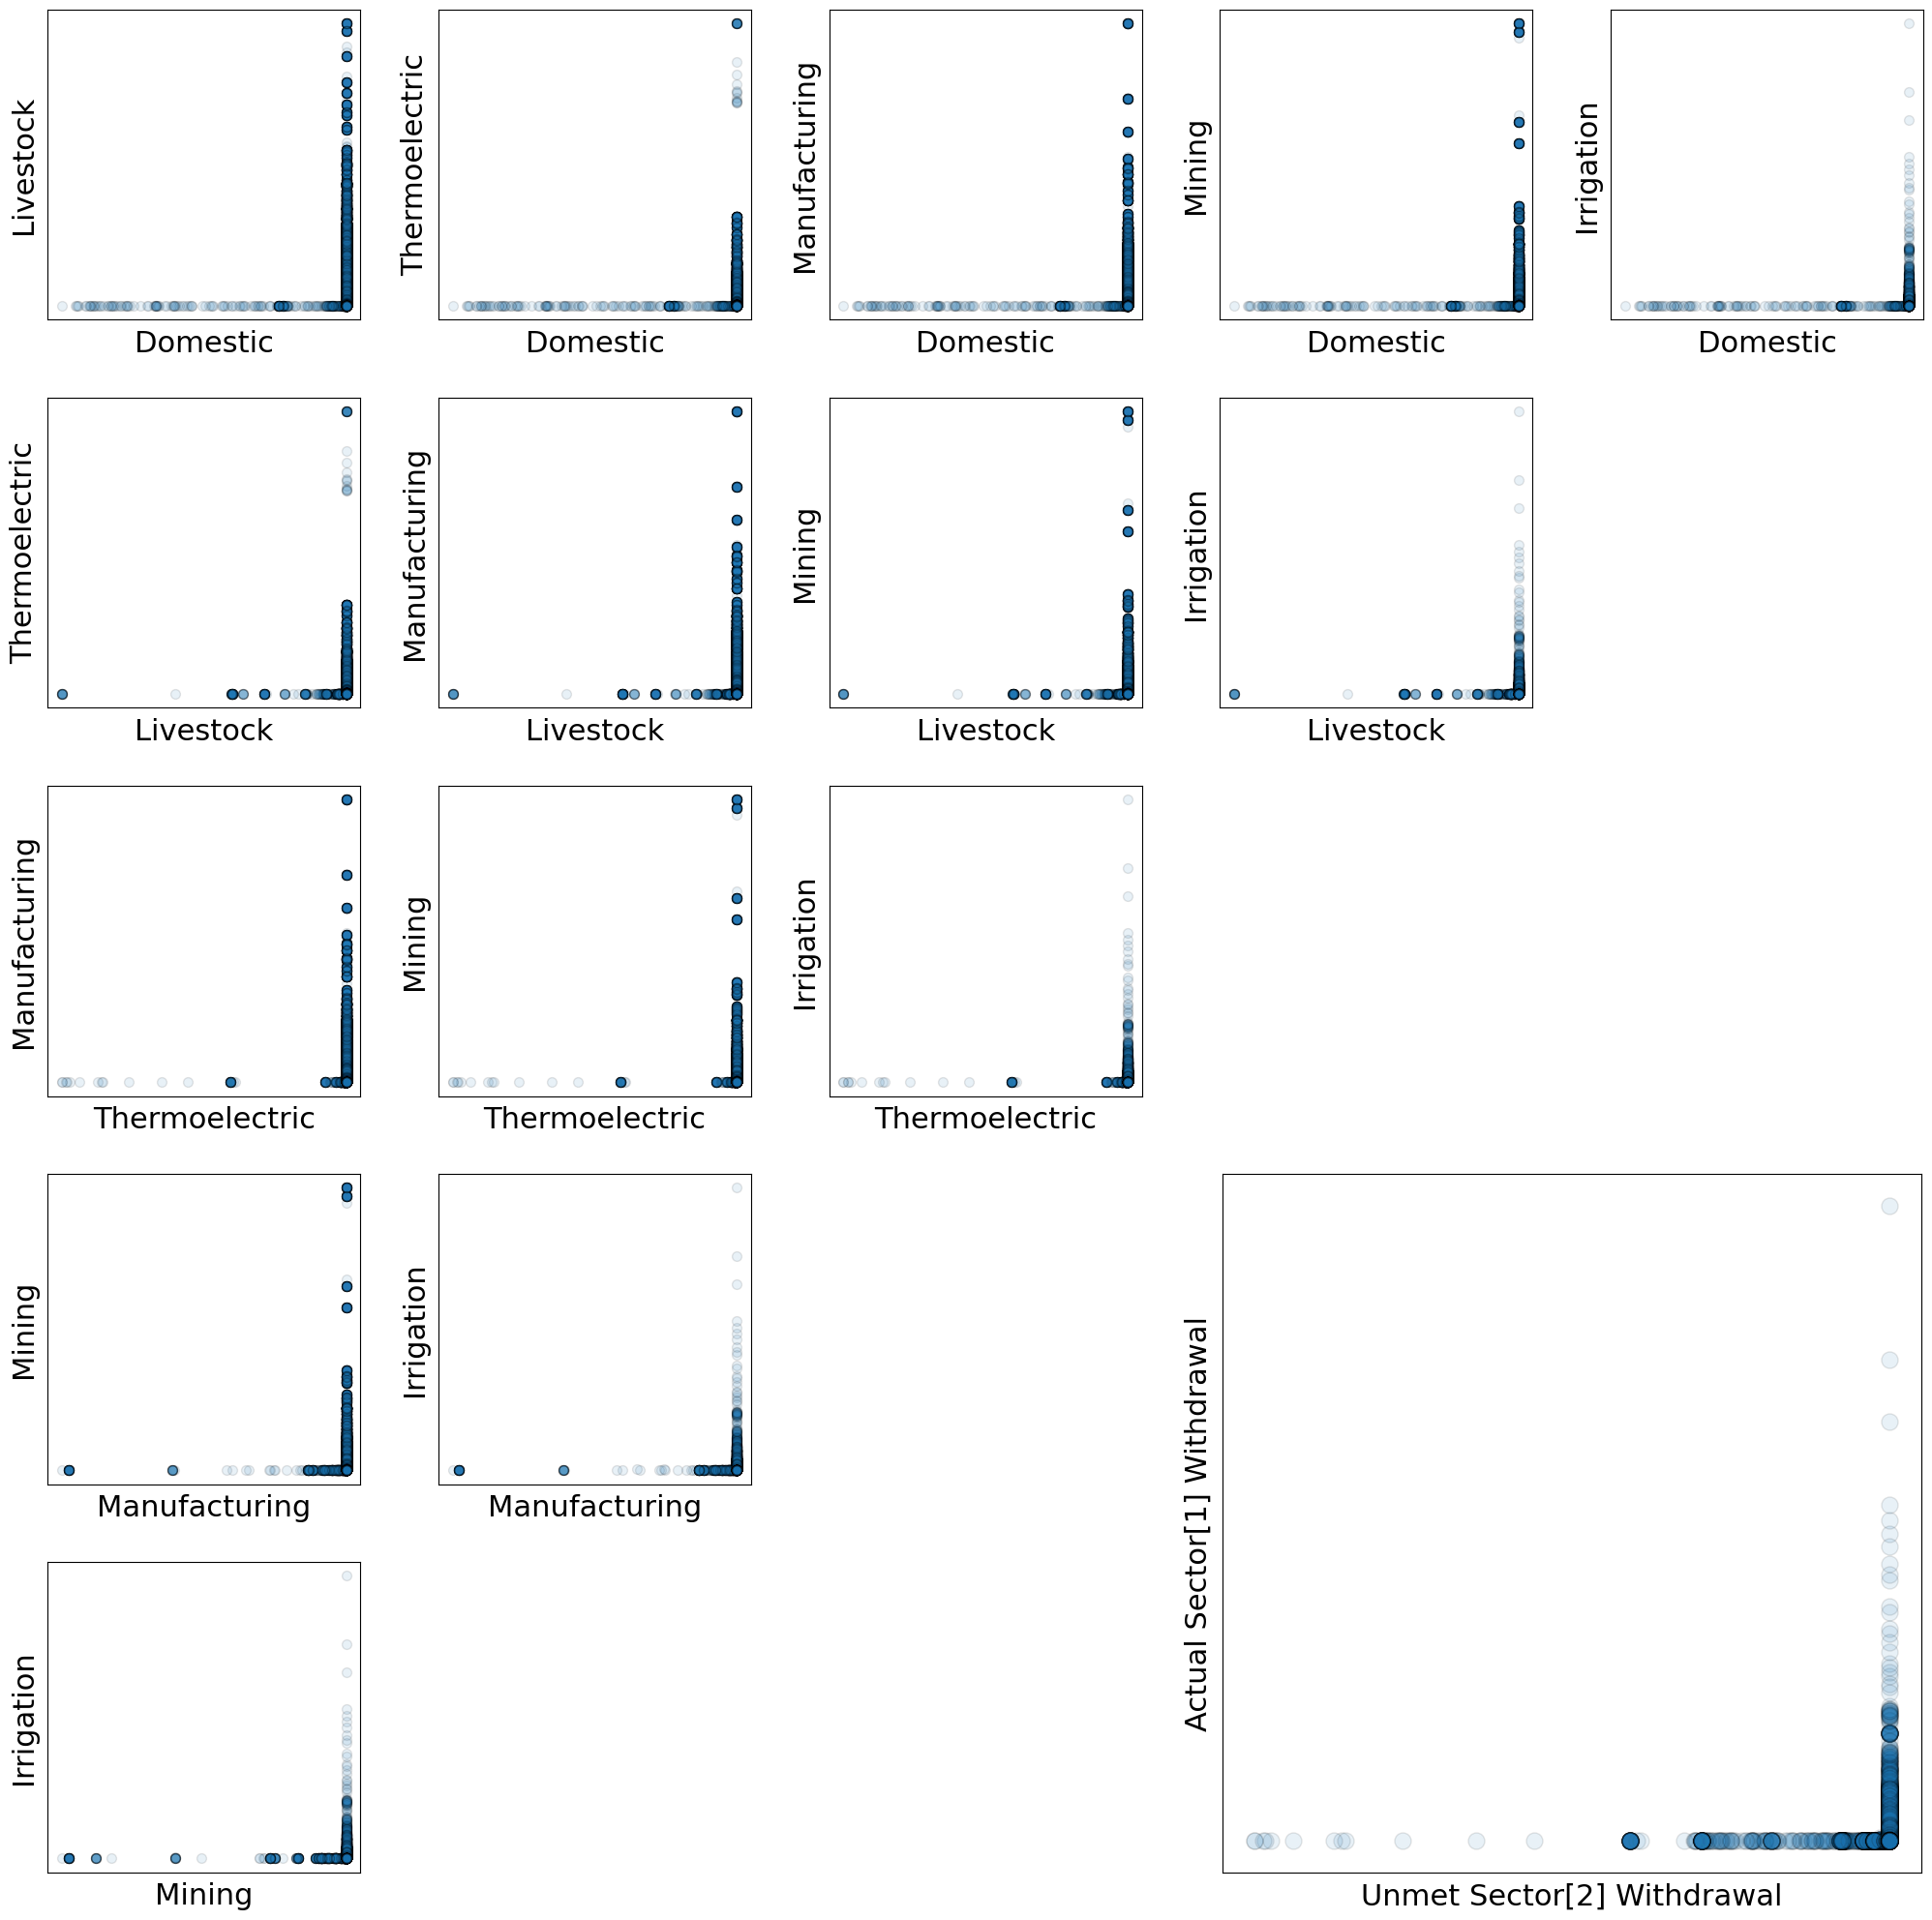

In [14]:
fig = plt.figure(figsize=(25, 25))

rows = 5
columns = 5

grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

ax1 = plt.subplot(grid[0, 0])
# ax1.set_xlabel('Unmet domestic withd', fontsize=22)
# ax1.set_ylabel('Actual livestock withd', fontsize=22)
ax1.set_xlabel('Domestic', fontsize=22)
ax1.set_ylabel('Livestock', fontsize=22)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
plt.scatter(actual_volumetric_data[0,:,:].ravel()[filter_dom_and_liv] - expected_volumetric_data[0,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[1,:,:].ravel()[filter_dom_and_liv], s=50, alpha=0.1, edgecolors="k")

ax2 = plt.subplot(grid[0, 1])
# ax2.set_xlabel('Unmet domestic withd', fontsize=22)
# ax2.set_ylabel('Actual thermoelectric withd', fontsize=22)
ax2.set_xlabel('Domestic', fontsize=22)
ax2.set_ylabel('Thermoelectric', fontsize=22)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.scatter(actual_volumetric_data[0,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[0,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[2,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")

ax3 = plt.subplot(grid[0, 2])
# ax3.set_xlabel('Unmet domestic withd', fontsize=22)
# ax3.set_ylabel('Actual manufacturing withd', fontsize=22)
ax3.set_xlabel('Domestic', fontsize=22)
ax3.set_ylabel('Manufacturing', fontsize=22)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_xticks([])
ax3.set_yticks([])
plt.scatter(actual_volumetric_data[0,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[0,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[3,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax4 = plt.subplot(grid[0, 3])
# ax4.set_xlabel('Unmet domestic withd', fontsize=22)
# ax4.set_ylabel('Actual mining withd', fontsize=22)
ax4.set_xlabel('Domestic', fontsize=22)
ax4.set_ylabel('Mining', fontsize=22)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_xticks([])
ax4.set_yticks([])
plt.scatter(actual_volumetric_data[0,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[0,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[4,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


plt.subplot(grid[0, 4])
ax5 = plt.subplot(grid[0, 4])
# ax5.set_xlabel('Unmet domestic withd', fontsize=22)
# ax5.set_ylabel('Actual irrigation withd', fontsize=22)
ax5.set_xlabel('Domestic', fontsize=22)
ax5.set_ylabel('Irrigation', fontsize=22)
ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xticks([])
ax5.set_yticks([])
plt.scatter(actual_volumetric_data[0,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[0,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[5,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax6 = plt.subplot(grid[1, 0])
# ax6.set_xlabel('Unmet livestock withd', fontsize=22)
# ax6.set_ylabel('Actual thermoelectric withd', fontsize=22)
ax6.set_xlabel('Livestock', fontsize=22)
ax6.set_ylabel('Thermoelectric', fontsize=22)
ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xticks([])
ax6.set_yticks([])
plt.scatter(actual_volumetric_data[1,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[1,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[2,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")



ax7 = plt.subplot(grid[1, 1])
# ax7.set_xlabel('Unmet livestock withd', fontsize=22)
# ax7.set_ylabel('Actual manufacturing withd', fontsize=22)
ax7.set_xlabel('Livestock', fontsize=22)
ax7.set_ylabel('Manufacturing', fontsize=22)
ax7.set_xticklabels([])
ax7.set_yticklabels([])
ax7.set_xticks([])
ax7.set_yticks([])
plt.scatter(actual_volumetric_data[1,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[1,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[3,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")



ax8 = plt.subplot(grid[1, 2])
# ax8.set_xlabel('Unmet livestock withd', fontsize=22)
# ax8.set_ylabel('Actual mining withd', fontsize=22)
ax8.set_xlabel('Livestock', fontsize=22)
ax8.set_ylabel('Mining', fontsize=22)
ax8.set_xticklabels([])
ax8.set_yticklabels([])
ax8.set_xticks([])
ax8.set_yticks([])
plt.scatter(actual_volumetric_data[1,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[1,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[4,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")

ax9 = plt.subplot(grid[1, 3])
# ax9.set_xlabel('Unmet livestock withd', fontsize=22)
# ax9.set_ylabel('Actual irrigation withd', fontsize=22)
ax9.set_xlabel('Livestock', fontsize=22)
ax9.set_ylabel('Irrigation', fontsize=22)
ax9.set_xticklabels([])
ax9.set_yticklabels([])
ax9.set_xticks([])
ax9.set_yticks([])
plt.scatter(actual_volumetric_data[1,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[1,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[5,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax10 = plt.subplot(grid[2, 0])
# ax10.set_xlabel('Unmet thermoelectric withd', fontsize=22)
# ax10.set_ylabel('Actual manufacturing withd', fontsize=22)
ax10.set_xlabel('Thermoelectric', fontsize=22)
ax10.set_ylabel('Manufacturing', fontsize=22)
ax10.set_xticklabels([])
ax10.set_yticklabels([])
ax10.set_xticks([])
ax10.set_yticks([])
plt.scatter(actual_volumetric_data[2,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[2,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[3,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax11 = plt.subplot(grid[2, 1])
# ax11.set_xlabel('Unmet thermoelectric withd', fontsize=22)
# ax11.set_ylabel('Actual mining withd', fontsize=22)
ax11.set_xlabel('Thermoelectric', fontsize=22)
ax11.set_ylabel('Mining', fontsize=22)
ax11.set_xticklabels([])
ax11.set_yticklabels([])
ax11.set_xticks([])
ax11.set_yticks([])
plt.scatter(actual_volumetric_data[2,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[2,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[4,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")

ax12 = plt.subplot(grid[2, 2])
# ax12.set_xlabel('Unmet thermoelectric withd', fontsize=22)
# ax12.set_ylabel('Actual irrigation withd', fontsize=22)
ax12.set_xlabel('Thermoelectric', fontsize=22)
ax12.set_ylabel('Irrigation', fontsize=22)
ax12.set_xticklabels([])
ax12.set_yticklabels([])
ax12.set_xticks([])
ax12.set_yticks([])
plt.scatter(actual_volumetric_data[2,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[2,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[5,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax13 = plt.subplot(grid[3, 0])
# ax13.set_xlabel('Unmet manufacturing withd', fontsize=22)
# ax13.set_ylabel('Actual mining withd', fontsize=22)
ax13.set_xlabel('Manufacturing', fontsize=22)
ax13.set_ylabel('Mining', fontsize=22)
ax13.set_xticklabels([])
ax13.set_yticklabels([])
ax13.set_xticks([])
ax13.set_yticks([])
plt.scatter(actual_volumetric_data[3,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[3,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[4,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax14 = plt.subplot(grid[3, 1])
# ax14.set_xlabel('Unmet manufacturing withd', fontsize=22)
# ax14.set_ylabel('Actual irrigation withd', fontsize=22)
ax14.set_xlabel('Manufacturing', fontsize=22)
ax14.set_ylabel('Irrigation', fontsize=22)
ax14.set_xticklabels([])
ax14.set_yticklabels([])
ax14.set_xticks([])
ax14.set_yticks([])
plt.scatter(actual_volumetric_data[3,:,:].ravel()[filter_dom_and_elec] - expected_volumetric_data[3,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[5,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")


ax15 = plt.subplot(grid[4, 0])
# ax15.set_xlabel('Unmet mining withd', fontsize=22)
# ax15.set_ylabel('Actual irrigation withd', fontsize=22)
ax15.set_xlabel('Mining', fontsize=22)
ax15.set_ylabel('Irrigation', fontsize=22)
ax15.set_xticklabels([])
ax15.set_yticklabels([])
ax15.set_xticks([])
ax15.set_yticks([])
plt.scatter(actual_volumetric_data[4,:,:].ravel()[filter_dom_and_elec] -  expected_volumetric_data[4,:,:].ravel()[filter_dom_and_liv], actual_volumetric_data[5,:,:].ravel()[filter_dom_and_liv],s=50, alpha=0.1, edgecolors="k")

# Aggregating data for the large subplot
x_data_aggregate = np.concatenate([
    actual_volumetric_data[0, :, :].ravel()[filter_dom_and_liv] - expected_volumetric_data[0, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[1, :, :].ravel()[filter_dom_and_elec] - expected_volumetric_data[1, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[2, :, :].ravel()[filter_dom_and_elec] - expected_volumetric_data[2, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[3, :, :].ravel()[filter_dom_and_elec] - expected_volumetric_data[3, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[4, :, :].ravel()[filter_dom_and_elec] - expected_volumetric_data[4, :, :].ravel()[filter_dom_and_liv]
])

y_data_aggregate = np.concatenate([
    actual_volumetric_data[1, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[2, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[3, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[4, :, :].ravel()[filter_dom_and_liv],
    actual_volumetric_data[5, :, :].ravel()[filter_dom_and_liv]
])

# Creating the large subplot at positions [3,3], [3,4], [4,3], and [4,4]
ax_large = plt.subplot(grid[3:5, 3:5])
ax_large.set_box_aspect(0.7/0.7)
ax_large.scatter(x_data_aggregate, y_data_aggregate, s=150, alpha=0.1, edgecolors='k')
ax_large.set_xlabel('Unmet Sector[2] Withdrawal', fontsize=22)
ax_large.set_ylabel('Actual Sector[1] Withdrawal', fontsize=22)
ax_large.set_xticklabels([])
ax_large.set_yticklabels([])
ax_large.set_xticks([])
ax_large.set_yticks([])

plt.savefig("Results/png_format/SectoralCompetitionValidation.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)

plt.show()
